# Book Recommender --- Part 2 (Weighted rating, Naive Bayes, SVM)

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)


import re
from tqdm import tqdm_notebook as tqdm
import collections
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDClassifier
from math import sqrt



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\YaoDe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Weighted rating approach

On the website of goodreads.com, each book has a score which was denoted by "A book’s total score is based on multiple factors, including the number of people who have voted for it and how highly those voters ranked the book." I could not find the formula it uses and find the weighted rating formula applied by IMDB as follows:

Weighted Rating (WR) = $(\frac{v}{v + M} . r) + (\frac{M}{v + M} . C)$

where,
* *v* is the number of ratings for the book
* *M* is the minimum number of ratings required to be listed in the chart
* *r* is the average rating of the book
* *C* is the average rating across the whole dataset

I will use the above formula to generate the book weighted raing score:


In [2]:
books_df=pd.read_csv('./goodreads/books.csv')
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2970 entries, 0 to 2969
Data columns (total 8 columns):
bookID          2970 non-null int64
title           2970 non-null object
rating          2970 non-null float64
authorName      2970 non-null object
authorID        2970 non-null int64
ratingCount     2970 non-null int64
reviewCount     2970 non-null int64
descriptions    2970 non-null object
dtypes: float64(1), int64(4), object(3)
memory usage: 185.7+ KB


In [3]:
books_df.describe()

,bookID,rating,authorID,ratingCount,reviewCount
count,2.970000e+03,2970.000000,2.970000e+03,2.970000e+03,2970.000000
mean,1.055459e+07,3.991845,3.304039e+06,1.193733e+05,5257.852525
std,1.231637e+07,0.287949,4.752905e+06,3.744048e+05,11870.970362
min,1.000000e+00,1.990000,4.000000e+00,1.000000e+00,0.000000
25%,1.878102e+05,3.810000,1.999150e+04,1.218000e+03,150.500000
50%,6.592829e+06,3.980000,5.623635e+05,1.555900e+04,1267.500000
75%,1.762291e+07,4.160000,5.164958e+06,7.316450e+04,4821.000000
max,5.509869e+07,5.000000,2.061176e+07,6.975016e+06,171390.000000


In [4]:
books_df.head()

,bookID,title,rating,authorName,authorID,ratingCount,reviewCount,descriptions
0,3,Harry Potter and the Sorcerer's Stone,4.47,J.K. Rowling,1077326,6975016,111040,Harry Potter's life is miserable. His parents ...
1,28187,The Lightning Thief,4.25,Rick Riordan,15872,1971943,60413,Alternate cover for this ISBN can be found her...
2,41865,Twilight,3.60,Stephenie Meyer,941441,4928162,104104,About three things I was absolutely positive.F...
3,2767052,The Hunger Games,4.33,Suzanne Collins,153394,6330340,171390,WINNING MEANS FAME AND FORTUNE.LOSING MEANS CE...
4,3636,The Giver,4.13,Lois Lowry,2493,1768831,64993,Twelve-year-old Jonas lives in a seemingly ide...


In [5]:
C=books_df['rating'].mean()
print(f'The average rating across the whole dataset C={C}')
#We only keep the books have number of ratings more than 80% of the books in the list
M=books_df['ratingCount'].quantile(0.8)
print(f'The minimum number of ratings required to be listed in the chart M= {M}')
books_chart=books_df[books_df['ratingCount']>M].copy()

The average rating across the whole dataset C=3.9918451178451164
The minimum number of ratings required to be listed in the chart M= 103296.60000000002


In [6]:
# The books qulified for the chart
books_chart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594 entries, 0 to 2957
Data columns (total 8 columns):
bookID          594 non-null int64
title           594 non-null object
rating          594 non-null float64
authorName      594 non-null object
authorID        594 non-null int64
ratingCount     594 non-null int64
reviewCount     594 non-null int64
descriptions    594 non-null object
dtypes: float64(1), int64(4), object(3)
memory usage: 41.8+ KB


In [7]:
def weighted_rating(x):
    v=x['ratingCount']
    r=x['rating']
    return (v/(v+M) * r) + (M/(M+v) * C)

In [8]:
books_chart['WR']=books_chart.apply(weighted_rating,axis=1)
books_chart.sort_values('WR',ascending=False).head(100)

,bookID,title,rating,authorName,authorID,ratingCount,reviewCount,descriptions,WR
2203,5,Harry Potter and the Prisoner of Azkaban,4.57,J.K. Rowling,1077326,2776134,54873,Harry Potter's third year at Hogwarts is full ...,4.549259
2335,1,Harry Potter and the Half-Blood Prince,4.57,J.K. Rowling,1077326,2415569,39114,The war against Voldemort is not going well; e...,4.546290
2502,6,Harry Potter and the Goblet of Fire,4.56,J.K. Rowling,1077326,2569982,46063,Harry Potter is midway through his training as...,4.538046
1917,862041,Harry Potter Series Box Set,4.74,J.K. Rowling,1077326,249286,7341,"Over 4000 pages of Harry Potter and his world,...",4.520812
1620,17332218,Words of Radiance,4.75,Brandon Sanderson,38550,202739,12275,"Words of Radiance, Book Two of the Stormlight ...",4.494099
955,7235533,The Way of Kings,4.64,Brandon Sanderson,38550,295765,19713,According to mythology mankind used to live in...,4.472226
1570,62291,A Storm of Swords,4.54,George R.R. Martin,346732,661511,22127,An alternate cover for this isbn can be found ...,4.465965
0,3,Harry Potter and the Sorcerer's Stone,4.47,J.K. Rowling,1077326,6975016,111040,Harry Potter's life is miserable. His parents ...,4.463022
299,186074,The Name of the Wind,4.53,Patrick Rothfuss,108424,706743,41621,"Told in Kvothe's own voice, this is the tale o...",4.461374
1136,18512,The Return of the King,4.53,J.R.R. Tolkien,656983,672519,9982,Alternate cover edition here.The Companions of...,4.458347


The top 100 books of the chart are as above. It looks that the weighted ratings of Harry Potter serires are the highest among the 3000 books.  

# 2. Naive Bayes and SVM to predict rating
Each book has a description which is like summary or excerpt of the book which gives us a rough idea of the topic, theme or the style. I will use Naive Bayes and SVM to train and predict the book ratings,and measure the model performance with root-mean-square.

<ol>
<li>Convert the book descriptions into vectors with Count Vectorizer and TD-iDF Vectorizer.</li> 

<li>Train model on whole dateset: split the books dateset into train and test dataset,train Naive Bayes and SVM model on the train dateset, then use the trained model to predict the ratings for test dataset.</li>

<li>Train model on each user individually: for a specific user, gather all the books the user has rated, split the data into train and test set, train the model as above and predict the rating for test set. </li>

</ol>

In [9]:
books_df=pd.read_csv('./goodreads/books.csv')
books_df['bookID']=books_df['bookID'].astype('str')
books_df['authorID']=books_df['authorID'].astype('str')

In [10]:
#use TF-iDF vertorizer to processing the features
tf = TfidfVectorizer(analyzer='word',min_df=0, stop_words='english')
tf_matrix=tf.fit_transform(books_df['descriptions'])
tf_matrix.shape

(2970, 27205)

In [11]:
#use count vertorizer to processing the features
count_vect = CountVectorizer()
count_matrix = count_vect.fit_transform(books_df['descriptions'])
count_matrix.shape

(2970, 27502)

## 2.1 Train the model on whole books dataset

In [12]:
#mapping the numerical rating to categorical label
def transform_label(x):
    if x<2: 
        return 1
    elif x>=2 and x<3:
        return 2
    elif x>=3 and x<4:
        return 3
    elif x>=4 and x<5:
        return 4
    else:
        return 5

books_df['label']=books_df['rating'].map(transform_label)

In [13]:
train, test = train_test_split(books_df,
                               test_size=0.20,
                               random_state=42)

In [14]:
def train_predict(vectorizer,model):
    matrix_train=vectorizer.transform(train['descriptions'])
    matrix_test=vectorizer.transform(test['descriptions'])
    label_train=train['label']
    label_test=test['label']
    model.fit(matrix_train,list(label_train))
    result=model.predict(matrix_test)
    mse_test=mean_squared_error(label_test,result)
    return sqrt(mse_test)

In [15]:
vectorizer=[]
rmse_result=[]

In [16]:
model=BernoulliNB()
rmse=train_predict(count_vect,model)
print(f'Count vectorizer and BernoulliNB, rmse={rmse}')
rmse=train_predict(tf,model)
vectorizer.append('Count')
rmse_result.append(rmse)
print(f'TF-iDF vecotrizer and BernoulliNB, rmse={rmse}')
vectorizer.append('TF-iDF')
rmse_result.append(rmse)


Count vectorizer and BernoulliNB, rmse=0.6474503217945908
TF-iDF vecotrizer and BernoulliNB, rmse=0.6369646031954254


In [17]:
model=MultinomialNB()
rmse=train_predict(count_vect,model)
print(f'Count vectorizer and BernoulliNB, rmse={rmse}')
rmse=train_predict(tf,model)
vectorizer.append('Count')
rmse_result.append(rmse)
print(f'TF-iDF vecotrizer and BernoulliNB, rmse={rmse}')
vectorizer.append('TF-iDF')
rmse_result.append(rmse)


Count vectorizer and BernoulliNB, rmse=0.6474503217945908
TF-iDF vecotrizer and BernoulliNB, rmse=0.6356417261637282


In [18]:
model=SGDClassifier(loss='hinge', penalty='l2',
                               alpha=1e-3, random_state=42,
                               max_iter=5, tol=None)
rmse=train_predict(count_vect,model)
print(f'Count vectorizer and BernoulliNB, rmse={rmse}')
rmse=train_predict(tf,model)
vectorizer.append('Count')
rmse_result.append(rmse)
print(f'TF-iDF vecotrizer and BernoulliNB, rmse={rmse}')
vectorizer.append('TF-iDF')
rmse_result.append(rmse)


Count vectorizer and BernoulliNB, rmse=0.7071067811865476
TF-iDF vecotrizer and BernoulliNB, rmse=0.631656472293207


In [19]:
df_results=pd.DataFrame({'Vectorizer':vectorizer,'RMSE':rmse_result,'Model':['BernoulliNB','BernoulliNB','MultinomialNB','MultinomialNB','SGDClassifier','SGDClassifier']})

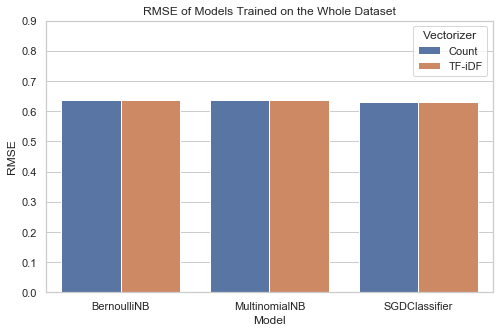

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y="RMSE", data=df_results,hue='Vectorizer')
plt.ylim(top=0.9)
plt.title('RMSE of Models Trained on the Whole Dataset')
plt.show()

From above experiements, **using TF-iDF vectorizer and SVM approach to predict the ratings attains the slightly better performance than the others**. However the rating predictions are the same for all users. Next, I will train the model on each user individually to get personized model for user. 

## 2.2 Train the model on each user individually

In [21]:
ratings=pd.read_csv('./goodreads/final_ratings.csv')
ratings['bookID']=ratings['bookID'].astype('str')
ratings['userID']=ratings['userID'].astype('str')
ratings['user_count']=ratings.groupby('userID')['userID'].transform('count') 
ratings=ratings[ratings['user_count']>100] #only train the model to each user who have rated no less than 100 books
userid_list=ratings['userID'].unique()

In [22]:
train, test = train_test_split(ratings,
                               stratify=ratings['userID'], 
                               test_size=0.20,
                               random_state=42)

In [23]:
def train_predict_user(train,test,vectorizer,model,matrix,books_df,userid_list):
    rmse_train_list=[] 
    rmse_test_list=[]
    for userid in tqdm(userid_list,desc="train and predict on each user individually"):
        user_rated_books = train.loc[train.userID ==userid].sort_values('bookID')
        user_discriptions=user_rated_books.merge(books_df,on='bookID')['descriptions']
        user_matrix=vectorizer.transform(user_discriptions)
        user_label=user_rated_books.merge(books_df,on='bookID')['rating_x']
        model.fit(user_matrix,user_label)
        result=model.predict(matrix)
        pred_df=pd.DataFrame({'bookID':books_df['bookID'].values,'result':result})
        #compute train accuracy
        y_true_train=train[train['userID']==userid].merge(pred_df,on='bookID')['rating']
        y_pred_train=train[train['userID']==userid].merge(pred_df,on='bookID')['result']
        rmse_train=sqrt(mean_squared_error(y_true_train,y_pred_train))
        rmse_train_list.append(rmse_train)        
        #compute the test accuracy using the best_threshhold for train dateset
        y_true_test=test[test['userID']==userid].merge(pred_df,on='bookID')['rating']
        y_pred_test=test[test['userID']==userid].merge(pred_df,on='bookID')['result']
        rmse_test=sqrt(mean_squared_error(y_true_test,y_pred_test))
        rmse_test_list.append(rmse_test)
    print(f'The mean rmse of prediction for train dataset is {np.mean(rmse_train_list)}')
    print(f'The mean rmse of prediction for test dataset is {np.mean(rmse_test_list)}')
    return np.mean(rmse_test_list)

In [24]:
vectorizer=[]
rmse_result=[]

In [25]:
model=BernoulliNB()
print("----------------------------------------------------------------------")
print('Count Vectorizer and BernoulliNB model,train on each user individually')
rmse=train_predict_user(train,test,count_vect,model,count_matrix,books_df,userid_list)
vectorizer.append('Count')
rmse_result.append(rmse)
print("----------------------------------------------------------------------")
print('TF-iDF Vectorizer and BernoulliNB model,train on each user individually')
rmse=train_predict_user(train,test,tf,model,tf_matrix,books_df,userid_list)
vectorizer.append('TF-iDF')
rmse_result.append(rmse)


----------------------------------------------------------------------
Count Vectorizer and BernoulliNB model,train on each user individually



The mean rmse of prediction for train dataset is 1.1460645496590303
The mean rmse of prediction for test dataset is 1.1745378562599165
----------------------------------------------------------------------
TF-iDF Vectorizer and BernoulliNB model,train on each user individually



The mean rmse of prediction for train dataset is 1.148032390491226
The mean rmse of prediction for test dataset is 1.1741271474451627


In [26]:
model=MultinomialNB()
print("----------------------------------------------------------------------")
print('Count Vectorizer and MultinomialNB model,train on each user individually')
rmse=train_predict_user(train,test,count_vect,model,count_matrix,books_df,userid_list)
vectorizer.append('Count')
rmse_result.append(rmse)
print("----------------------------------------------------------------------")
print('TF-iDF Vectorizer and MultinomialNB model,train on each user individually')
rmse=train_predict_user(train,test,tf,model,tf_matrix,books_df,userid_list)
vectorizer.append('TF-iDF')
rmse_result.append(rmse)

----------------------------------------------------------------------
Count Vectorizer and MultinomialNB model,train on each user individually



The mean rmse of prediction for train dataset is 0.8620966416570156
The mean rmse of prediction for test dataset is 1.182852779357975
----------------------------------------------------------------------
TF-iDF Vectorizer and MultinomialNB model,train on each user individually



The mean rmse of prediction for train dataset is 0.885150447769515
The mean rmse of prediction for test dataset is 1.1729097045919485


In [27]:
model=SGDClassifier(loss='hinge', penalty='l2',
                               alpha=1e-3, random_state=42,
                               max_iter=5, tol=None)
print("----------------------------------------------------------------------")
print('Count Vectorizer and SGDClassifier model,train on each user individually')
rmse=train_predict_user(train,test,count_vect,model,count_matrix,books_df,userid_list)
vectorizer.append('Count')
rmse_result.append(rmse)
print("----------------------------------------------------------------------")
print('TF-iDF Vectorizer and SGDClassifier model,train on each user individually')
rmse=train_predict_user(train,test,tf,model,tf_matrix,books_df,userid_list)
vectorizer.append('TF-iDF')
rmse_result.append(rmse)

----------------------------------------------------------------------
Count Vectorizer and SGDClassifier model,train on each user individually



The mean rmse of prediction for train dataset is 0.2512519457539975
The mean rmse of prediction for test dataset is 1.3207107132621603
----------------------------------------------------------------------
TF-iDF Vectorizer and SGDClassifier model,train on each user individually



The mean rmse of prediction for train dataset is 0.02143902036351592
The mean rmse of prediction for test dataset is 1.2004944148272834


In [28]:
df_results=pd.DataFrame({'Vectorizer':vectorizer,'RMSE':rmse_result,'Model':['BernoulliNB','BernoulliNB','MultinomialNB','MultinomialNB','SGDClassifier','SGDClassifier']})

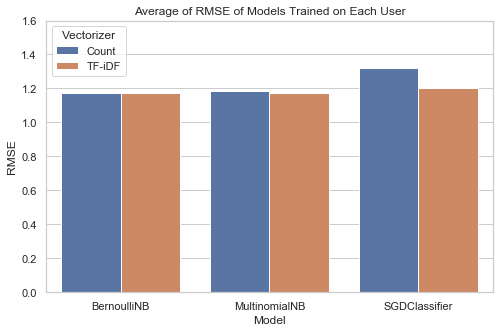

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(x='Model', y="RMSE", data=df_results,hue='Vectorizer')
plt.ylim(top=1.6)
plt.title('Average of RMSE of Models Trained on Each User')
plt.show()

Using TF-iDF vectorizer and BernoulliNB model has the best RMSE score 1.17 on test dataset. But even the best score from the experiments is far from a decent results. We need seek other approaches to build a good recommender system.